##ГЛУБОКОЕ ОБУЧЕНИЕ НЕЙРОННЫХ СЕТЕЙ

М21-181-1 

Перевощикова Д.А.

##ПРАКТИЧЕСКАЯ РАБОТА №2

Цель работы – научится реализовывать нейронные сети для распознавания
геометрических фигур на изображениях.

Задачи:
1. Изучить реализацию в TensorFlow нейронных сетей для распознавания
геометрических фигур на изображениях на примере.

2. Разработать и обучить нейронную сеть глубокого обучения для
распознавания геометрических фигур на изображениях.

3. Сформировать дополнительный тестовый набор данных, содержащий
геометрические фигуры. Увеличить сформированные наборы данных с
использованием встроенных средств TensorFlow.

4. Оценить точность распознавания на дополнительном наборе тестовых
данных


Импортируем необходимые библиотеки и зависимости:

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

Для проведения обучения нейронной сети будем использовать собственную выборку, составленную с помощью библиотеки сv2. Для этого создадим функцию добавления квадрата add_square

In [2]:
def add_square(img, center, width):
  start_point = (center[0]-width, center[1]-width)
  end_point   = (center[0]+width, center[1]+width)
  cv2.rectangle(img, start_point, end_point, random_color(),cv2.FILLED)

Нейронная сеть будет находить все окружности на рисунке, создадим датасет с помощью функции create_data_sample, случайно заполним пустые картинки с черным фоном квадратами и кругами разного цвета

In [3]:
def create_data_sample(num_shapes, height, width):
  img = np.zeros((height, width, 3))
  label = np.zeros((height, width, 1))
  for _ in range(num_shapes):
    x = int(np.random.rand()*width)
    y = int(np.random.rand()*height)
    if np.random.rand() > 0.5:
      cv2.circle(img, (x,y), int(np.ceil(width*0.05)), random_color(), cv2.FILLED)
      cv2.circle(label, (x,y), int(np.ceil(width*0.02)), (1,1,1), cv2.FILLED)
    else: 
      add_square(img, (x,y), int(np.ceil(width*0.05*0.7)))
  return img, label


Создадим различные вспомогательные функции.

In [4]:
def test_batch(num_shapes, height, width):
  img, label = create_data_sample(num_shapes, height, width)
  return np.expand_dims(img,0), np.expand_dims(label,0)

In [5]:
def grayscale_image(img):
  return np.expand_dims((img[:,:,0] + img[:,:,1] + img[:,:,2])/3,2)

In [6]:
# (128,128,1) --> (128,128,3)
def to_three_channels(img):
  return np.squeeze(np.stack((img,img,img), 2))

In [7]:
def random_color():
  return np.random.rand(3)

In [8]:
def show_sample(img, label):
  figure, axis = plt.subplots(1,2)
  axis[0].imshow(img)
  axis[1].imshow(to_three_channels(label))

In [9]:
def show_batch(img, label):
  show_sample(img[0,:,:,:],label[0,:,:,:])

С помощью функции show_sample выведем на экран пример элемента из выборки. На первом изображении показан первоначальный вид, на втором изображении продемонстрированы только центры окружностей.

(1, 128, 128, 3) (1, 128, 128, 1)


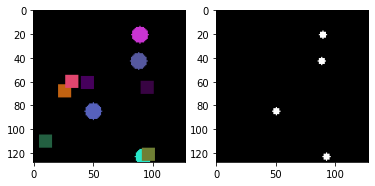

In [10]:
img_shape = (128,128,3)
img, label = test_batch(10, img_shape[0], img_shape[1])
print(img.shape, label.shape)
show_batch(img, label)

Для исследования будем использовать многослойную нейросеть - keras. Зададим некоторые параметры нейросети:

In [11]:
l2 = None
inputs = keras.Input(shape=img_shape)
conv1 = keras.layers.Conv2D(16,5,padding='same',activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2)(inputs)
conv1 = keras.layers.BatchNormalization(momentum=0.99)(conv1)
conv2 = keras.layers.Conv2D(32,5,padding='same',activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2)(conv1)
conv2 = keras.layers.BatchNormalization(momentum=0.99)(conv2)
outputs = keras.layers.Conv2D(1,5,padding='same',activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2)(conv2)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      1216      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 1)       801   

Для вычисления ошибки создадим функция loss_funtion

In [12]:
def loss_function(y_true, y_pred):
  squared_diff = tf.square(y_true - y_pred)
  return tf.reduce_mean(squared_diff)


Для обучения нейронной сети создадим выборку из 1000 изображений:

In [13]:
x_list = []
y_list = []
for i in range(1000):
  x,y  = create_data_sample(10, img_shape[0], img_shape[1])
  x_list.append(x)
  y_list.append(y)
x_list = np.array(x_list)
y_list = np.array(y_list)

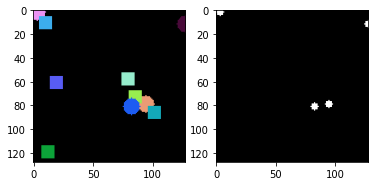

In [14]:
i = 3
show_sample(x_list[i], y_list[i])

Проверим размерность выборки

In [15]:
x_list.shape

(1000, 128, 128, 3)

Приступим к обучению модели:

In [16]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt,loss=loss_function)

In [17]:
model.fit(x_list,y_list,batch_size=100,epochs=100)

Epoch 1/100
10/10 [==============================] - 17s 92ms/step - loss: 2.0240
Epoch 2/100
10/10 [==============================] - 1s 92ms/step - loss: 0.6386
Epoch 3/100
10/10 [==============================] - 1s 92ms/step - loss: 0.2987
Epoch 4/100
10/10 [==============================] - 1s 93ms/step - loss: 0.2197
Epoch 5/100
10/10 [==============================] - 1s 92ms/step - loss: 0.1581
Epoch 6/100
10/10 [==============================] - 1s 93ms/step - loss: 0.1250
Epoch 7/100
10/10 [==============================] - 1s 92ms/step - loss: 0.1079
Epoch 8/100
10/10 [==============================] - 1s 96ms/step - loss: 0.0943
Epoch 9/100
10/10 [==============================] - 1s 98ms/step - loss: 0.0836
Epoch 10/100
10/10 [==============================] - 1s 97ms/step - loss: 0.0748
Epoch 11/100
10/10 [==============================] - 1s 93ms/step - loss: 0.0674
Epoch 12/100
10/10 [==============================] - 1s 94ms/step - loss: 0.0609
Epoch 13/100
10/10 [====

Для примера рассмотрим следующий элемент выборки:

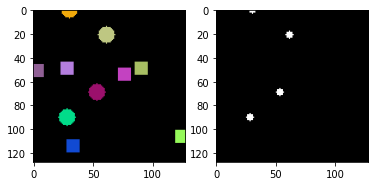

In [18]:
img, label = test_batch(10, img_shape[0], img_shape[1])
show_batch(img,label)

Для этого элемента сделаем прогноз:

1/1 [==============================] - 0s 144ms/step


2.2204282


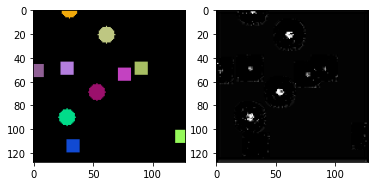

In [19]:
y_pred = model.predict(img)
print(y_pred.max())
show_batch(img, y_pred)

Как видно из прогноза, очертания окружностей практически полностью совпадают с реальным расположением окружностей.